Version 31.08.2023, A. S. Lundervold.

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HVL-ML/DAT158/blob/master/notebooks/DAT158-1.3-Binary_classification.ipynb) &nbsp; [![kaggle](https://camo.githubusercontent.com/a08ca511178e691ace596a95d334f73cf4ce06e83a5c4a5169b8bb68cac27bef/68747470733a2f2f6b6167676c652e636f6d2f7374617469632f696d616765732f6f70656e2d696e2d6b6167676c652e737667)](https://www.kaggle.com/alexanderlundervold/2023-dat158-1-3-binary-classification-ipynb)

# Introduction

This notebook, along with the subsequent one, goes through some core concepts related to **classification** in machine learning. 

It's based on the course textbook's Chapter 3. You should also have a look at Geron's notebook: https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb.

For our discussion, we'll primarily work with two data sets:
* The diabetes data set, which you might recall from a previous notebook. This represents a **binary classification problem** where we predict either a positive (True) or negative (False) outcome.
* The **MNIST** data set, which serves as an example of **multiclass classification** as it involves identifying handwritten digits from 0 to 9. 

This exploration is split across two notebooks: 

* `DAT158-1.4-Binary_classification` (the one you're currently viewing)
* `DAT158-1.5-Multiclass_classification`

> Before we get going, let's ask ourselves: what is classification and regression, and how do you distinguish them?

## Classification versus regression

**Classification**

Classification is about assigning a label or category to an input. We want to decide which of N classes an input belongs to. Remember the flowers from the slides in the first lecture? If we're trying to determine whether a given image is of a flower belonging to one of a specific set of possibilities, that's classification. 

Mathematically, it's the task of mapping inputs, $X$, to a set of labels: 

$$f: X \longrightarrow \{1, \dots, N\}.$$

This means we're dealing with a discrete outcome: every input is designated to a specific category or class, and the set of classes cover all possibilities. For instance, in an email spam filter, the two classes could be "spam" and "not spam" and every email is assigned to one or the other. 


It's one of the two main forms of **supervised learning**, the other one being **regression**.


**Regression**

Regression deals with predicting a continuous value. Consider the task of predicitng a house's price based on features of the house, like size, location, number of rooms, and so on. Here, the outcome is a specific value, say NOK 3 000 000, which can vary continuously over a range. 

Regression aims to find a function mapping from inputs to a continuous set:

$$f: X \longrightarrow \mathbb{R}.$$

You have a set of $x$-values (inputs) and corresponding outputs as real numbers ($y$-values). When given a new, previously unseen $x$-value, what $y$-value should you predict? What is the best interpolating function? 

### Classification or regression?

A key question to ask when faced with a new problem is:

> "Are the possible predictions continuous or discrete?"

For instance, predicting a house price of 1.500.000 versus 1.500.001 represents a miniscule change, indicative of a regression task. However, discerning whether an image contains a cat versus a dog likely makes a difference, and you should probably treat this as a classification problem.

# Setup

In [11]:
# To display plots directly in the notebook:
%matplotlib inline

We import our standard framework:

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [13]:
# Set the directory in which to store data
NB_DIR = Path.cwd()       # Set NB_DIR to be the current working directory
DATA = NB_DIR/'data'      # The data dir is the subdirectory 'data' under NB_DIR

DATA.mkdir(exist_ok=True) # Create the data directory

# Get the data: the diabetes data set

<img src='https://raw.githubusercontent.com/alu042/DAT158-2022/main/notebooks/assets/diabetes.jpg' width="40%">

Let's start by retrieving the diabetes dataset as done in our prior notebook. If you need a quick refresher on the dataset and its attributes, revisit the previous notebook.

In [14]:
import urllib.request

# Define the file path
FILE = DATA / 'diabetes.csv'

# Download the file if it doesn't exist
if not FILE.exists():
    url = 'https://assets.datacamp.com/production/course_1939/datasets/diabetes.csv'
    urllib.request.urlretrieve(url, FILE)

We use Pandas for loading and inspecting our dataset:

In [15]:
diabetes = pd.read_csv('data/diabetes.csv')

# Explore the data

In [16]:
diabetes.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Recall that our dataset has 768 entries:

In [17]:
len(diabetes)

768

Some are labeled as diabetes some as not-diabetes, with more not-diabetes than diabetes. The histogram below showcases the distribution of our target variable:

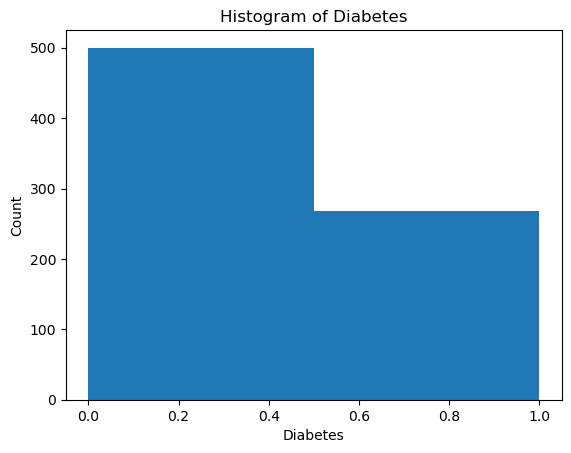

In [18]:
# Plot a histogram of the diabetes column
plt.hist(diabetes['diabetes'], bins=2)

# Add axis labels and a title
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.title('Histogram of Diabetes')

# Show the plot
plt.show()

Here's a description of each feature (from <a href="https://www.kaggle.com/uciml/pima-indians-diabetes-database">Kaggle</a>):
- Pregnancies: number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Diastolic: Diastolic blood pressure (mm Hg)
- Triceps: Triceps skin fold thickness (mm)
- Insulin: 2-hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DPF: Diabetes pedigree function
- Age: Age (years)
- Diabetes: Class variable (0 or 1)

We'll store the features in 'X' and the labels in 'y'. Our goal is to approximate the function mapping X to y:

$$y \approx f(x; \theta)$$

In [19]:
X = diabetes.drop('diabetes', axis=1)
y = diabetes['diabetes']

In [20]:
X.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [21]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: diabetes, dtype: int64

# Create training and test sets

Before any modeling, it's crucial to split our dataset into training and testing sets. Remember, our primary goal is to assess how our model generalizes to unseen data. Thus, the test set acts as a proxy for this "unseen" data.

The data in the test set will not be used for anything else than the final test of our machine learning model's accuracy. Using the test set during model design is a huge no-no since this will give a biased performance estimate when evaluating our model on the test set (i.e. we'll overfit to the test data set). 

> We're not interested in how well our models perform on the training set, what we're really after is how well they generalize to unseen data. 

The test set is meant to simulate unseen data (and should therefore not be touched when constructing and tuning our models). 

<img width=50% src="https://raw.githubusercontent.com/alu042/DAT158-2022/main/notebooks/assets/testsplit.png"> 

We'll randomly split off 25% of the data to be used as a test set:

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

(The random state is set to ensure that we get the same random split every time the cell is executed)

We now have 576 instances for training, 192 for testing:

In [23]:
len(X_train), len(X_test)

(576, 192)

# Training a classifier

We have a lot of choices when building our model, and we'll delve deeper into the options later in this course. For now, we'll use the `SGDClassifier`, a linear classifier optimized using stochastic gradient descent, as our model. We'll use it as a "black box", without studying how it works behind the scenes (but feel free to read more about the model [here](http://scikit-learn.org/stable/modules/sgd.html)). Our focus now is on classification in general, not on specific models.

In [24]:
from sklearn.linear_model import SGDClassifier

In [25]:
#?SGDClassifier

In [26]:
# Create an instance of the model:
sgd_clf = SGDClassifier(random_state=20)

In [27]:
# Train the model:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=20)

With our model trained, we can generate predictions on our test set:

In [28]:
y_pred = sgd_clf.predict(X_test)
y_pred[:10]  # Displaying the first 10 predictions

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0])

Here are the correct answers for the first 20 instances:

In [29]:
np.array(y_test)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1])

Let's put them next to each other and print out the first few:

In [30]:
print("True and predicted labels for the first 20 instances:")
print(list(zip(y_test, y_pred))[:20])

True and predicted labels for the first 20 instances:
[(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (1, 1), (0, 1), (1, 1), (0, 1), (0, 0), (1, 1), (0, 0), (0, 1), (1, 1), (1, 1)]


We observe that the model is correct some times, incorrect others. 

> **But how good is the model, really?** 

We need ways to evaluate and validate models..

# Evaluating models / performance measures

Before delving into metrics and methods, it's crucial to ask, "What is the end goal for my system?" Ultimately, we aim to build systems that serve a higher purpose in some larger context. Sometimes, there are trade-offs to consider, like sacrificing accuracy for speed or ensuring specific types of errors are minimized.

However, for simplicity, we will set aside these broader contextual concerns for now.

## Accuracy and different sorts of errors

Accuracy, or the fraction of correct predictions, is often the first metric we consider in classification.

But there are different kinds of errors in binary classification. If we classify something as belonging to the positive class, we can either be correct (**true positive**) or incorrect (**false positive**). If we classify something as negative, we can either be correct (**true negative**) or incorrect (**false negative**). 

* True Positive (TP): Correctly classified positive instances.
* False Positive (FP): Incorrectly classified positive instances.
* True Negative (TN): Correctly classified negative instances.
* False Negative (FN): Incorrectly classified negative instances.

The type of errors we prioritize can vary. For instance, in medical diagnosis, reducing false negatives (missed diagnoses) can be paramount, but we'd also want to keep an eye on false positives to avoid unnecessary interventions. 

For spam filtering, ensuring vital emails aren’t marked as spam (low FP) might be more important, even if that means occasionally letting some spam through (higher FN).

For computing accuracy, we can use the `accuracy_score` function from `sklearn.metrics`:

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5416666666666666

This model predicts correctly about 54% of the time.

## Validation set and model selection

**Model selection** is the process of picking the best model and tuning its parameters. It's crucial to avoid using the test set during this phase to prevent "leaking" information and overfitting. Otherwise, we'll have no way to produce an unbiased estimate of how well the final model will generalize to new data, as we've used information from our test set to design the model. 

Instead, we split the training data into a training set and a **validation set**, and use the validation set to evaluate performance as we try out different models and model configurations.

We've seen this idea used earlier in the course and know how to do this using the `train_test_split` function.

<img src="https://raw.githubusercontent.com/alu042/DAT158-2022/main/notebooks/assets/trainvaltestset.png" width="40%">

> **Your turn!**
- Split `(X_train, y_train)` into two parts: one for training one for validation. You can call the new data sets and label sets `X_train_new, X_val, y_train_new, y_val`. Hint: Use the `train_test_split` function.
- Train your model again on the new training set, and compute its accuracy on the validation set using the `score` method (in the case of classifiers, this computes the `accuracy_score` automatically, as we did above): `model.score(X_val, y_val)` 
- Is the result good? What accuracy would a purely random classifier achieve?
- Play around with some of the parameters of `SGDClassifier` and try to improve the result on the validation set. Once you've found some parameters that seem promising, test on the test set: `model.predict(X_test)` and `model.score(X_test, y_test)` (If you want to be thorough, use grid search to test parameter combinations). Note that, as mentioned above, it is essential to not use the test data set until you've done all of the model selection work (selecting which model to use, what parameter settings it should have, and so on). Otherwise, the models will be tuned on the test data set. It will no longer give a realistic simulation of new data coming in, and therefore the score achieved on the test set will provide a biased generalization performance estimate.

<details>
    <summary>Click <font color="red"><b>here</b></font> for a solution</summary>
    
To split the data into training and validation sets, we can use the `train_test_split` function from `sklearn.model_selection`:

```
from sklearn.model_selection import train_test_split
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train)
```

After training your model on this new subset, evaluate its performance using the `score` method:
```
model.score(X_val, y_val)
```

</details>

## Cross-validation

Another frequently used way to do validation is *cross-validation*.

The idea is to randomly split the training set into several parts, called *folds*. Say into K folds, for example. Then, train a model K times, each time using a different fold for evaluation and training on the remaining K-1. The average score for the K runs is used to estimate the model's performance. 

This means that *each sample in the training set is part of the training set K-1 times and the evaluation set once*. 

<img src="https://raw.githubusercontent.com/alu042/DAT158-2022/main/notebooks/assets/K-fold_cross_validation_EN.jpg"><br>
<span style="font-size:70%">Image from <a href="https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.jpg">Wikipedia</a></span>

An important advantage of this approach over the one above is that it doesn't waste as much training data. Unless you have plenty of data, cross-validation is the preferred method for estimating model performance.

Cross-validation also provides a more thorough test than splitting the data into training and test sets. The `train_test_split` procedure sets aside a fixed random subset of the data as a test set. If we're unlucky, all the difficult examples end up in the training set, while the test set contains only easy ones. That would lead to an overestimate of the actual performance of our model.

Note: The special case of cross-validation where K is set to the number of data points in the training set is called *leave-one-out*. Each fold is then a single sample.

This K-fold cross validation procedure results in an array of K evaluation scores.

> We'll use the cross-validation approach in the rest of this notebook. 

The following demonstrates 5-fold cross-validation:

In [32]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(sgd_clf, X_train, y_train, cv=5, 
                            scoring='accuracy', n_jobs=-1)

In [33]:
print(cv_scores)

[0.62068966 0.55652174 0.34782609 0.65217391 0.68695652]


In [34]:
cv_scores.mean()

0.5728335832083958

The mean accuracy of our model on the five folds is about 57.3%, which, on the surface, looks pretty good!

...but is it really? Remember that there were more non-diabetes instances than diabetes instances. 

In fact, there are a total of 500 non-diabetes instances and 268 diabetes:

In [35]:
diabetes['diabetes'].value_counts()

0    500
1    268
Name: diabetes, dtype: int64

Therefore, if we guessed that everyone belongs to the non-diabetes class, we would achieve an accuracy of...

In [36]:
y_dummy = [0,]*len(y_test) # This creates a list of 0 with the same length as `y_test`
accuracy_score(y_test, y_dummy)

0.640625

...64%! 

This is **The Trap of Unbalanced Datasets**.  In cases where one class dominates, a naive classifier predicting the majority class will still have high accuracy.

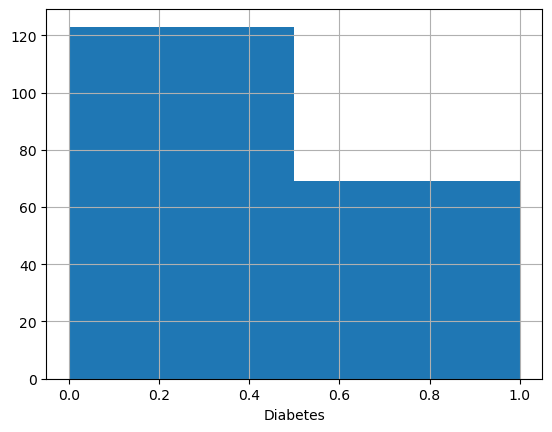

In [37]:
y_test.hist(bins=2)
plt.xlabel('Diabetes')
plt.show()

Guessing "non-diabetic" for all instances yields an accuracy of around 64%. In unbalanced datasets, metrics other than accuracy become crucial.

> Note that accuracy isn't always the best metric even in balanced datasets, especially when the consequences of certain types of misclassifications (like false negatives or false positives) are significantly different.

> **Your turn:** Many machine learning models, like the `SGDClassifier`, perform better if the input data is appropriately scaled. Try using the `StandardScaler` in scikit-learn to standardize the training data. Then feed it through `cross_val_score`. You could also try the `MinMaxScaler`. 

> Hint: `from sklearn.preprocessing import StandardScaler, MinMaxScaler`. 

## Confusion matrix

A confusion matrix is a table summarizing the results from a classification model's predictions. In what way is the classifier "confused"? What errors does it tend to make?

The idea is to count the number of times instances of a specific class is classified as the various classes in your problem. In our case, how often the diabetes and non-diabetes are correctly classified, how often a non-diabetes is misclassified as diabetes, and how often a diabetes is misclassified as a diabetes.

We need to produce some predictions to compare with the true classes. We can use `cross_val_predict`, which works similarly to `cross_val_score` except that it returns predictions based on all the K folds.

In [38]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=5, n_jobs=-1)

We now want to compare...

In [39]:
y_train_pred

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

...to

In [40]:
np.array(y_train)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,

Here's the confusion matrix:

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_train_pred)
print(cm)

[[226 151]
 [ 95 104]]


We can plot it as follows:

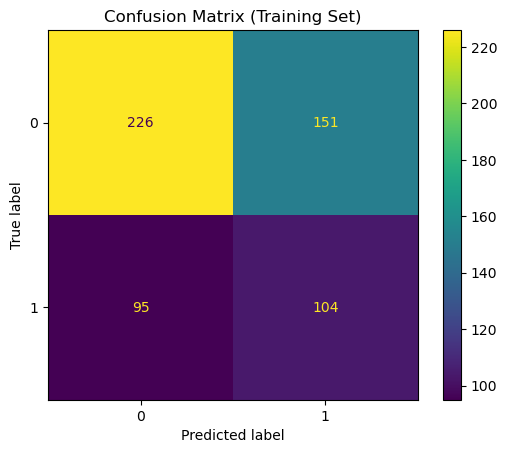

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title('Confusion Matrix (Training Set)')
plt.show()

Each row in the matrix represents a class: non-diabetes and diabetes. Each column represents a predicted class. 

The first row shows that 226 instances were correctly classified as non-diabetes (**true negatives**). There were 151 instances classified as diabetes that were really non-diabetes (**false positives**).

The second row tells us that 95 diabetes instances were wrongly labelled as non-diabetes (**false negatives**), while the remaining 104 diabetes instances were correctly classified (**true positives**). 

> **Your turn!** How would the confusion matrix of a perfect classifier be?

These numbers tell us a lot about classifier performance. But sometimes, it's helpful to quantify (i.e., compute numbers) how much our classifier deviates from a perfect classifier.

## Precision, recall, and specificity

For binary classification problems, where there are only two possible classes, three important metrics are **precision**, **recall**, and **specificity**.

Let's first understand some notations:

* P = All actual positive data points
* N = All actual negative data points
* TP = True positives (correctly identified positives)
* FP = False positives (negatives wrongly identified as positives)
* TN = True negatives (correctly identified negatives)
* FN = False negatives (positives wrongly identified as negatives)

> Your turn! What are the values of these numbers for the above classifier?

The **precision** of a binary classifier is **the proportion of the positive predictions that were actually correct**. In other words, 

$$precision = \frac{true\,positives}{positive\, predictions} = \frac{TP}{TP + FP}.$$

> **Your turn!** What's the precision of the classifier above? What's the precision of a _perfect_ classifier? If a classifier has perfect precision, is it necessarily a good classifier?

The **recall** (or sensitivity or true positive rate) of a binary classifier is **the proportion of actual positives that were correctly identified**. In other words, 

$$recall = \frac{true\, positives}{all\, actual\, positives} = \frac{TP}{P} = \frac{TP}{TP+FN}$$


> **Your turn!** What's the recall of the classifier above? What's the recall of a _perfect_ classifier? If a classifier has perfect recall, is it necessarily a good classifier?

The **specificity** (or true negative rate) of a binary classifier is **the proportion of actual negatives that were correctly identified**. In other words,

$$specificity = \frac{true\, negatives}{all\, actual\, negatives} = \frac{TN}{TN + FP}$$

> **Your turn!** Consider the classifier above. What's its precision, recall, and specificity? For a perfect classifier, how would these metrics look? Can a classifier with a perfect value in one metric still be flawed?

<img width=40% src="https://raw.githubusercontent.com/alu042/DAT158-2022/main/notebooks/assets/Precisionrecall.png">

<span style=font-size:80%>Illustration from Wikipedia</span>

### Connection to the confusion matrix

The confusion matrix provides values of TP, FP, FN, and TN, which can be used to compute precision, recall, and specificity:

In [43]:
cm

array([[226, 151],
       [ 95, 104]])

In [44]:
# Using elements from a two-dimensional array
tn, fp, fn, tp = cm.ravel()

These values allow for the computation of the metrics:

In [45]:
precision = tp / ( tp + fp )
recall = tp / ( tp + fn )
specificity = tn / ( tn + fp )

In [46]:
print(f"Precision: {precision}\n Recall: {recall}\n Specificity: {specificity}")

Precision: 0.40784313725490196
 Recall: 0.5226130653266332
 Specificity: 0.5994694960212201


However, `scikit-learn` offers built-in methods:

In [47]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))

0.40784313725490196
0.5226130653266332


> **Your turn!** Which is more critical: high precision or high recall? 

> **Your turn!** A question to ponder: How would you define precision and recall if you have more than two classes?

## $F_1$ score

Since you typically care about both precision and recall, it can sometimes make sense to combine them into one number (for example when comparing two classifiers). 

The **$F_1​$** score combines both precision and recall into a single metric, the harmonic mean:

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

The harmonic mean is used because it provides a low score if either precision or recall is low (close to 9), effectively penalizing classifiers that have a significant disparity between these two metrics.

For example, if the precision is 0.0001 and the recall is 1, the $F_1$ score will be close to 0, while the artihmetic mean would be (0.0001 + 1) / 2 ~ 0.5. 

An $F_1$ score of 1.0 means perfect precision *and* perfect recall (i.e. a perfect classifier).

> **Your turn!** Say you have two classifiers A and B, with

$$
\begin{align}
precision_A = 0.7,\quad &recall_A = 0.6 \\
precision_B = 0.3,\quad &recall_B = 1
\end{align}
$$

> What are the corresponding arithmetic means of the two models? What are their $F_1$ scores? You'll notice that model B's bad precision results in a lower $F_1$ compared to model A.

Using scikit-learn, we can compute the $F_1$ score easily:

In [48]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.4581497797356828

> **Your turn!** Remember that I asked you to try to construct a better `SGDClassifier` model by normalizing the data before it is put into the model. If you haven't done so already, please try. Then run your predictions through the above set of evaluation methods.

Here's a solution. Don't peek until you've tried yourself. :-) 

In [49]:
import os
import urllib.request
from urllib.error import HTTPError

# Define the URL and file name of the script
url = 'https://raw.githubusercontent.com/HVL-ML/DAT158/master/notebooks/solutions/1.3-1-sgd_normalized.py'
filename = '1.3-1-sgd_normalized.py'

# Download the script from GitHub
try:
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded {filename} successfully.")
except HTTPError as e:
    print(f"Failed to download {filename}: {e}")

# Load the script into the notebook
filepath = os.path.join(os.getcwd(), filename)
%load {filepath}


Downloaded 1.3-1-sgd_normalized.py successfully.


```
if not (colab or kaggle):
    # Load the script into the notebook
    filename = '1.3-1-sgd_normalized.py'
    filepath = os.path.join(os.getcwd(), 'solutions/'+filename)
    %load {filepath}
```

In [50]:
# Load the script into the notebook
filename = '1.3-1-sgd_normalized.py'
filepath = os.path.join(os.getcwd(), 'solutions/'+filename)
%load {filepath}

We'll use the classifier trained on the normalized data in what follows. (**Note:** you have to do the above exercise and save the data as `X_train_scaled`, `X_test_scaled` and the SGD model as `sgd_clf_scaled` for the below cell to work.)

In [51]:
# sgd_clf = sgd_clf_scaled
# 
# X_train = X_train_scaled
# X_test = X_test_scaled

## Precision/recall tradeoff

It's typically challenging to achieve both high precision and high recall simultaneously; improving one can deteriorate the other. This tradeoff is due to the threshold set for making decisions in classification.

Let's try to understand why

A classifier with perfect recall is easy to construct: just predict that everything is diabetes! Then there are no false negatives and the recall is 1.0. Perfect. Except, the precision will be rubbish.

To get high precision, make a classifier predict *one* instance as diabetes that you're very sure is correct, and the rest as non-diabetes. Then the number of false positives will likely be 0, and the precision 1.0. The recall will however be really bad as there will be many false negatives. 

We can see this principle in action for our `SGDClassifier`. But we'll have to discuss what's going on behind the scenes when we ran `sgd_cl.fit` on our training data...

_Fitting_ or _training_ the `SGDClassifier` means finding a _hyperplane_, or a _boundary_, in the data space that separates the diabetes instances from the non-diabetes as much as possible. 

When feeding `SGDClassifer` a data point it decides whether it is a diabetes or a non-diabetes based on the _distance_ from the data point to this hyperplane. By default, if the data point has a negative distance to the plane, the model predicts that it's from the negative class (a non-diabetes in our case). If the distance is positive, it's predicted to be from the positive class (a diabetes instances). In other words, the **decision threshold** is set to 0 by default. 

Furthermore, the distance from the data point to the hyperplane can be interpreted as how _certain_ the model is about its prediction. The larger the distance, the more certain the model. 

***Where you set the threshold makes a big difference***.

If the distance between a data point and a classifier's decision boundary is beyond a certain threshold, it might be classified as positive; otherwise, it's classified as negative.

Let's do some experiments on an example to investigate further. We'll use the first instance in the test data set:

In [52]:
# Features
X_test[0]

KeyError: 0

In [ ]:
# Label
y_test.iloc[0]

`SGDClassifier` has a method that computes the distance of a data point from the hyperplane:

In [ ]:
y_example_score = sgd_clf.decision_function([X_test[0]])

In [ ]:
print(y_example_score)

Let's play with the threshold:

In [ ]:
threshold = 0
y_example_pred = (y_example_score > threshold)
print(f"Is it a diabetes instance? {y_example_pred}")

In [ ]:
threshold = -10
y_example_pred = (y_example_score > threshold)
print(f"Is it a diabetes instance? {y_example_pred}")

You can see that increasing the threshold for classifying something as diabetes makes the model less likely to do so. *This increases the precision of the classifier, but reduces its recall.* Decreasing the threshold has the opposite effect: higher recall, lower precision.

Let's plot this.

First we compute the decision function score for all the training data:

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=2, method='decision_function')

We get 576 scores, one for each training example:

In [ ]:
y_scores.shape

Now, let's compute and plot the precisions and recalls for various thresholds:

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute the precision and recall scores for different threshold values
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Now we can visualize the precision/recall tradeoff:

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.title("Precision and Recall vs. Threshold", fontsize=18)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Where you set the threshold will depend on the specific problem. For instance, in spam detection, a high precision (less false positives) might be desired, even if it means having a slightly lower recall.

Remember, while it's possible to achieve any desired precision by adjusting the threshold, it's essential to consider the accompanying recall value.

It's very easy to create a classifier with any precision you want, as long as you don't care about recall. You just have to select a suitable threshold. 

For example

In [ ]:
y_train_pred_precise = (y_scores > 18)
precision_score(y_train, y_train_pred_precise)

In [ ]:
recall_score(y_train, y_train_pred_precise)

> If someone says "let's reach 90% precision!", you should ask, "at what recall?" &mdash; Aurelien Geron

As the F1 score is a kind of mean between precision and recall, it can be used to catch models who trades off a lot of precision for high recall or vice versa:

In [ ]:
from ipywidgets import interact

In [ ]:
@interact(threshold=(-20, 20, 1))
def get_f1_score(threshold=0):
    f1_score_greater = f1_score(y_train, (y_scores > threshold))
    f1_score_smaller = f1_score(y_train, (y_scores < threshold))
    print(f"y_scores > threshold: {f1_score_greater:.3f}")
    print(f"y_scores < threshold: {f1_score_smaller:.3f}")

## Comparing classifiers

Metrics like the F1 score provide tools for comparing classifiers. These metrics are not only more convenient than assessing curves, but they also facilitate automated model selection.

Let's illustrate this by introducing another classifier for our task: the random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Generate cross-validation predictions on the training set
y_train_pred_rf = cross_val_predict(rf_clf, X_train, y_train, cv=3)

# Print the shape of the predicted labels array
print("Shape of the predicted labels array:")
print(y_train_pred_rf.shape)

We get:

In [ ]:
# Compute the F1 score for the two classifiers
f1_sgd = f1_score(y_train, y_train_pred)
f1_rf = f1_score(y_train, y_train_pred_rf)

# Print the F1 scores for the two classifiers
print("F1 scores for the classifiers:")
print(f"RandomForestClassifier: {f1_rf:.3f}")
print(f"SGDClassifier: {f1_sgd:.3f}")

From the scores above, the Random Forest classifier appears to be the preferable choice. However, there might be other aspects not captured by the F1 score that could sway our decision towards the SGDClassifier.

Examining the confusion matrices can provide more context:

In [ ]:
print(confusion_matrix(y_train, y_train_pred_rf))

In [ ]:
print(confusion_matrix(y_train, y_train_pred))

The confusion matrix for the Random Forest is generally more favorable than the SGD classifier. However, the SGDClassifier detects one more true positive than the Random Forest.

An essential consideration is also the computational efficiency:

In [ ]:
%%time 
cross_val_score(rf_clf, X_train, y_train, cv=3).mean()

In [ ]:
%%time 
cross_val_score(sgd_clf, X_train, y_train, cv=3).mean()

While the Random Forest may perform better in terms of F1 score, it's slower. Depending on the application, this might influence our model choice. This depends on the "bigger picture": What the model is supposed to be used for, and as part of what pipeline or workflow.  

# Final test of classifiers

After these experiments, we can make a final performance check against the test data. This will provide our estimate of the model's generalization performance.

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

**Your turn!** Plot the confusion matrix using the test data and the Random Forest predictions. Then, compute its precision, recall, specificity, and F1 score.

# Summary so far

Some of the things we've learned so far:

- The process of training a binary classifier.
- Choosing appropriate metrics for the task
- The advantage of cross-validation for robust model assessment.
- Selecting appropriate precision/recall tradeoffs
- Comparing models using F1 scores

> Evaluating a classification model goes beyond just checking its accuracy. It's essential to consider the specific context and implications of false positives and false negatives. By understanding and employing a combination of metrics like precision, recall, and the F1-score, we can gain a more holistic view of our model's performance.

# Next

In the next notebook, we'll take a look at multiclass classification. 